In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import mpmath
import dill as pickle
import sinter
import qc_utils.stats
import qc_utils.matplotlib_setup as mpl_setup
import multiprocess as mp

from ray_delay.noise_model_patch import NoiseModelPatch
from ray_delay.noise_model import RayModelType
from ray_delay.ray_detector import RayDetectorSpec, RayImpactSimulator
from stim_surface_code.memory import MemoryPatch
from stim_surface_code.patch import Qubit, DataQubit, MeasureQubit

In [2]:
dx = 7
dz = 7
dm = 3

patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))

baseline_ler = patch.patch.count_logical_errors(10**7, max_errors=500)[0]
print(baseline_ler)

baseline_detector_rate = np.mean(patch.patch.count_detection_events(10**5)[0])
print(baseline_detector_rate)

7.619333563235158e-05
0.016512083333333333


In [3]:
radii = np.linspace(1, 7, 100)

def get_num_cycles(radius):
    if radius >= 6:
        num_cycles = 10*6*3
    elif radius >= 4:
        num_cycles = 10*6*3
    elif radius >= 3:
        num_cycles = 10*6*3
    elif radius >= 2:
        num_cycles = 10*6*3
    else:
        num_cycles = 10*6*3
    return num_cycles

def get_signal_chance_and_task(i):
    patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))
    center_qubit = patch.patch.device[dx][dz].idx
    patch.force_cosmic_ray(center_qubit, radii[i])

    ray_detector_rate = np.mean(patch.patch.count_detection_events(10**5)[0])
    task = patch.patch.get_sinter_task(task_kwargs={'json_metadata':{'i':i}})

    return ray_detector_rate, task

with mp.Pool(6) as pool:
    combined_results = pool.map(get_signal_chance_and_task, range(len(radii)))

detector_rates_direct = [result[0] for result in combined_results]
tasks_direct = [result[1] for result in combined_results]

In [4]:
results_direct = sinter.collect(tasks=tasks_direct, num_workers=6, decoders='pymatching', max_shots=10**6, max_errors=500)

In [5]:
lers_direct = [None]*len(radii)
radii = [0]*len(radii)
for task_result in results_direct:
    lers_direct[task_result.json_metadata['i']] = task_result.errors / task_result.shots

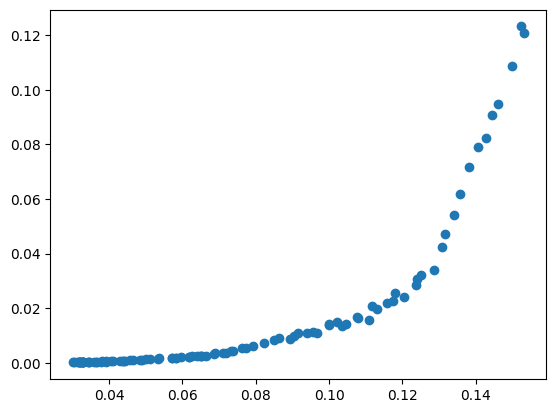

In [6]:
plt.scatter(detector_rates_direct, lers_direct)

In [7]:
min_radius = 1
max_radius = 7
num_rays = 1000

def get_num_cycles(radius):
    if radius >= 6:
        num_cycles = 10*6*3
    elif radius >= 4:
        num_cycles = 10*6*3
    elif radius >= 3:
        num_cycles = 10*6*3
    elif radius >= 2:
        num_cycles = 10*6*3
    else:
        num_cycles = 10*6*3
    return num_cycles

def get_signal_chance_and_task(i):
    patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))
    patch.noise_model._noise_params.cosmic_ray_params.model = RayModelType.SCRAMBLING
    center_qubit = patch.patch.device[dx][dz].idx
    radius = np.random.uniform(min_radius, max_radius)
    patch.force_cosmic_ray(center_qubit, radius)

    ray_detector_rate = np.mean(patch.patch.count_detection_events(10**5)[0])
    task = patch.patch.get_sinter_task(task_kwargs={'json_metadata':{'i':i, 'radius':radius}})

    return ray_detector_rate, task

with mp.Pool(6) as pool:
    combined_results = pool.map(get_signal_chance_and_task, range(num_rays))

detector_rates_scrambling = np.array([result[0] for result in combined_results])
tasks_scrambling = [result[1] for result in combined_results]

In [8]:
results_scrambling = sinter.collect(tasks=tasks_scrambling, num_workers=6, decoders='pymatching', max_shots=10**6, max_errors=500)

In [9]:
lers_scrambling = np.zeros(num_rays)
radii = np.zeros(num_rays)
for task_result in results_scrambling:
    lers_scrambling[task_result.json_metadata['i']] = task_result.errors / task_result.shots
    radii[task_result.json_metadata['i']] = task_result.json_metadata['radius']

(0.0, 0.15)

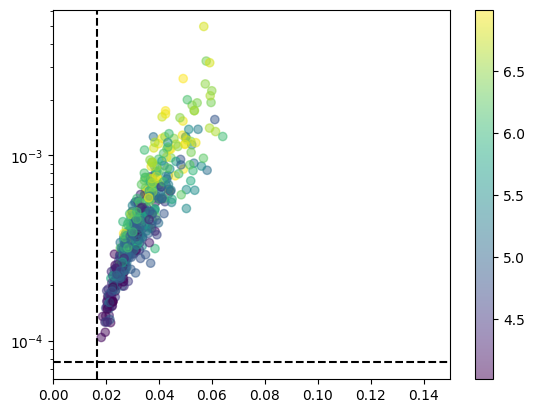

In [10]:
plt.scatter(detector_rates_scrambling[radii > 4], lers_scrambling[radii > 4], c=radii[radii > 4], alpha=0.5)
plt.colorbar()
plt.axhline(baseline_ler, color='black', linestyle='--')
plt.axvline(baseline_detector_rate, color='black', linestyle='--')
plt.yscale('log')
plt.xlim(0,0.15)

(0.0, 0.15)

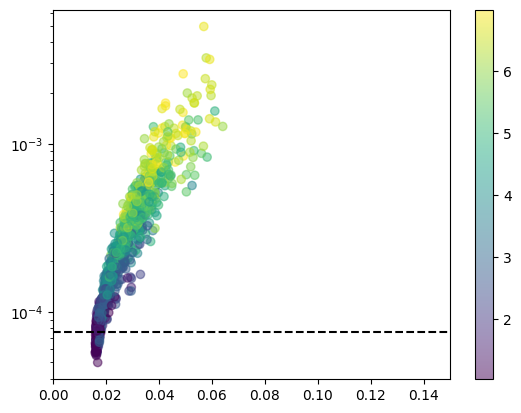

In [11]:
plt.scatter(detector_rates_scrambling, lers_scrambling, c=radii, alpha=0.5)
plt.colorbar()
plt.axhline(baseline_ler, color='black', linestyle='--')
plt.yscale('log')
plt.xlim(0,0.15)